## Purpose
Original repo: [DeepLearning-FromPaper](https://github.com/NinaM31/DeepLearning-FromPaper).    

This is my implementation of [Deep Convolutional Generative Adversarial Networks (DCGAN)](https://arxiv.org/pdf/1511.06434.pdf) paper, on the monet problem.

# Imports

In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

# Custom Dataset

In [2]:
class Dataset(Dataset):
    
    def __init__(self, img_dir):
        path_list = os.listdir(img_dir)
        abspath = os.path.abspath(img_dir)

        self.img_list = [os.path.join(abspath, path) for path in path_list]

        self.transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])


    def __len__(self):
        return len(self.img_list)


    def __getitem__(self, index):
        path = self.img_list[index]
        img = Image.open(path).convert('RGB')
        return self.transform(img)

# Discriminator Class

In [3]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, conv_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
   
            nn.Conv2d(conv_dim, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(conv_dim * 4, conv_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
          
            nn.Conv2d(conv_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )


    def forward(self, x):
        return self.main(x)

# Generator Class

In [4]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=64):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d( z_size, conv_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.ReLU(True),
           
            nn.ConvTranspose2d( conv_dim * 4, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.ReLU(True),
           
            nn.ConvTranspose2d( conv_dim * 2, conv_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(True),
          
            nn.ConvTranspose2d( conv_dim, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )


    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1) 
        return self.main(x)

# DCGAN Class

In [5]:
class DCGAN:

    def __init__(self, z_size, conv_dim):
        self.z_size = z_size

        self.D = Discriminator(conv_dim)
        self.G = Generator(z_size, conv_dim)

        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
        self.D.to(self.device)
        self.G.to(self.device)

        self.D.apply(self.weights_init)
        self.G.apply(self.weights_init)

        
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

            
    def describe(self):
        print('Discriminator')
        print(self.D)

        print('\nGenerator')
        print(self.G)

    
    def __calculate_loss(self, output, labels):
        criterion = nn.BCELoss()
        return criterion(output.squeeze(), labels)


    def real_loss(self, D_out):
        batch_size = D_out.size(0)
        labels = torch.ones(batch_size).to(self.device)*0.8

        return self.__calculate_loss(D_out, labels) 


    def fake_loss(self, D_out):
        batch_size = D_out.size(0)
        labels = torch.ones(batch_size).to(self.device)*0.1
 
        return self.__calculate_loss(D_out, labels)


    def noise(self, size):
        z = np.random.uniform(-1, 1, size=size)
        return torch.from_numpy(z).float().to(self.device)


    def train_generator(self, g_optim, size):
        g_optim.zero_grad()

        z = self.noise(size)
        fake_images = self.G(z)
        
        d_fake = self.D(fake_images)

        g_loss = self.real_loss(d_fake)

        g_loss.backward()
        g_optim.step()

        return g_loss.item()

    
    def train_discriminator(self, d_optim, real_images, size):
        d_optim.zero_grad()

        d_real = self.D(real_images.to(self.device)).view(-1)
        d_real_loss = self.real_loss(d_real)

        z = self.noise(size)
        fake_images = self.G(z)
      
        d_fake = self.D(fake_images)
        d_fake_loss = self.fake_loss(d_fake)

        d_loss = d_real_loss + d_fake_loss

        d_loss.backward()
        d_optim.step()

        return d_loss.item()


    def train(self, num_epochs, d_optim, g_optim, data_loader, z_size, sample_size, print_every=500):
        samples, losses = [], []

        z = self.noise((sample_size, z_size))

        self.D.train()
        self.G.train()

        print(f'Running on {self.device}')
        for epoch in range(num_epochs):
            for i, real_images in enumerate(data_loader):                    
                batch_size = real_images.size(0)

                d_loss = self.train_discriminator(d_optim, real_images, (sample_size, z_size))
                g_loss = self.train_generator(g_optim, (sample_size, z_size))

                if i % print_every == 0:
                    print('Epoch [{:5d}/{:5d}] | d_loss {:6.4f} | g_loss {:6.4f}'.format(
                        epoch+1,
                        num_epochs,
                        d_loss,
                        g_loss
                    ))

            losses.append( (d_loss, g_loss) )

            self.G.eval()
            samples.append( self.G(z) )
            self.G.train()

        with open('DCGAN_Sample_Output.pkl', 'wb') as f:
            pkl.dump(samples, f)

        return samples, losses 

# Let's Generate Art


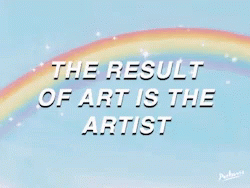

In [6]:
DATA_DIR = '../input/gan-getting-started/monet_jpg'

BATCH_SIZE = 16
N_WORKERS = 0

Z_SIZE = 128
SAMPLE_SIZE = 16
CONV_DIM = 64

lr = 0.0002
beta1=0.5
beta2=0.999

EPOCHS = 500

In [7]:
# Dataset
monet_dataset = Dataset(DATA_DIR)
data_loader = DataLoader(monet_dataset, BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)


# Model
dcgan_model = DCGAN(Z_SIZE, CONV_DIM)

# Oprimizer
d_optimizer = optim.Adam(dcgan_model.D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(dcgan_model.G.parameters(), lr, [beta1, beta2])

# train
sample_result, losses_history = dcgan_model.train(EPOCHS, d_optimizer, g_optimizer, data_loader, Z_SIZE, SAMPLE_SIZE, print_every=1000)

Running on cuda
Epoch [    1/  500] | d_loss 2.1401 | g_loss 2.7231
Epoch [    2/  500] | d_loss 1.1865 | g_loss 7.2737
Epoch [    3/  500] | d_loss 2.1880 | g_loss 8.5804
Epoch [    4/  500] | d_loss 1.6011 | g_loss 3.9925
Epoch [    5/  500] | d_loss 1.0604 | g_loss 5.7672
Epoch [    6/  500] | d_loss 0.9430 | g_loss 3.1494
Epoch [    7/  500] | d_loss 1.1339 | g_loss 5.2061
Epoch [    8/  500] | d_loss 1.4520 | g_loss 6.0219
Epoch [    9/  500] | d_loss 0.8597 | g_loss 2.9468
Epoch [   10/  500] | d_loss 0.8641 | g_loss 2.5167
Epoch [   11/  500] | d_loss 1.0027 | g_loss 3.4187
Epoch [   12/  500] | d_loss 1.0995 | g_loss 2.0529
Epoch [   13/  500] | d_loss 0.9599 | g_loss 1.5143
Epoch [   14/  500] | d_loss 1.0845 | g_loss 2.3997
Epoch [   15/  500] | d_loss 0.9177 | g_loss 2.0444
Epoch [   16/  500] | d_loss 1.0949 | g_loss 1.6613
Epoch [   17/  500] | d_loss 1.1930 | g_loss 3.1357
Epoch [   18/  500] | d_loss 0.8811 | g_loss 2.3730
Epoch [   19/  500] | d_loss 1.0040 | g_loss 2.3

# Results

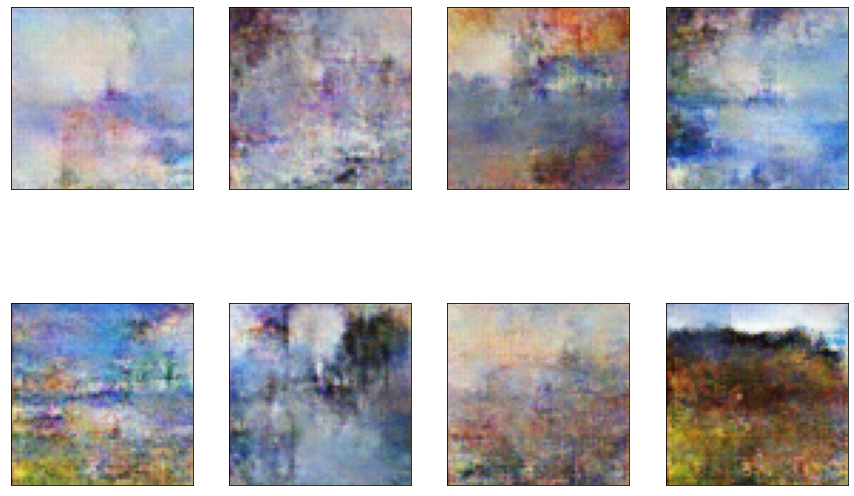

In [8]:
fig, axes = plt.subplots(figsize=(15,10), nrows=2, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), sample_result[EPOCHS-1]):
    _, w, h = img.size()
     
    img = img.detach().cpu().numpy()

    img = np.transpose(img, (1, 2, 0))
    
    img = ((img +1)*255 / (2)).astype(np.uint8)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    im = ax.imshow(img.reshape((w,h,3)))

plt.show()

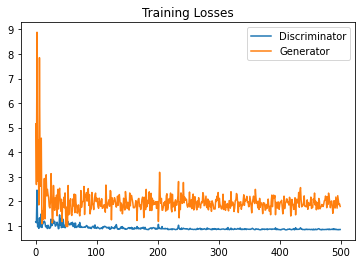

In [9]:
fig, ax = plt.subplots()
losses = np.array(losses_history)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
plt.show()